### Part 5



**Data investigation**

          x
0  0.000000
1  0.000000
2  0.043702
3  0.244185
4  0.228373


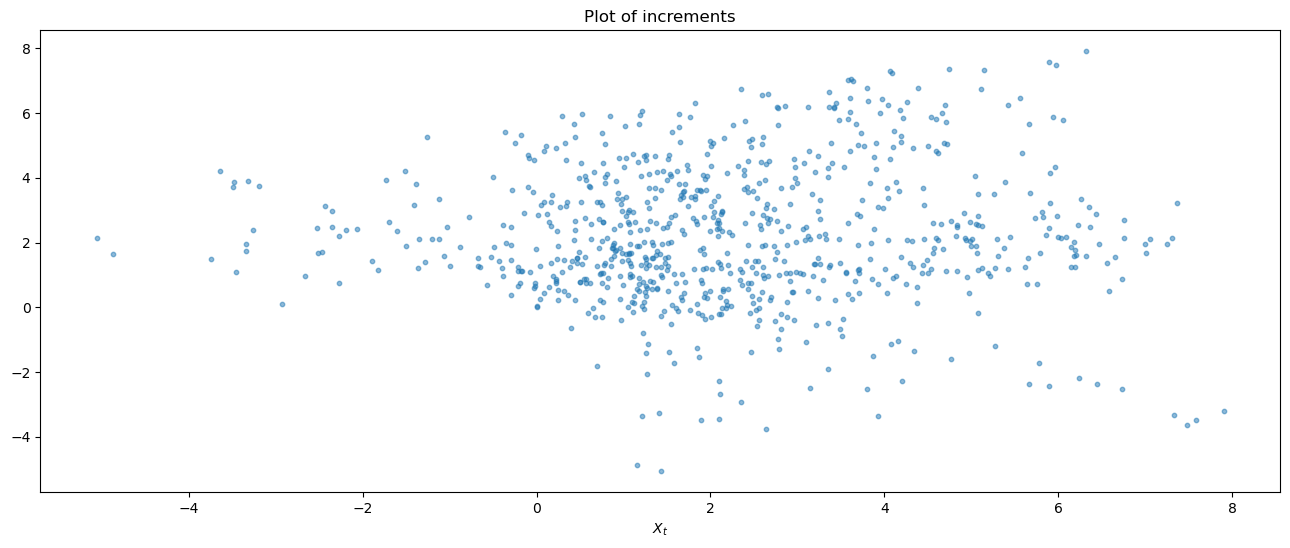

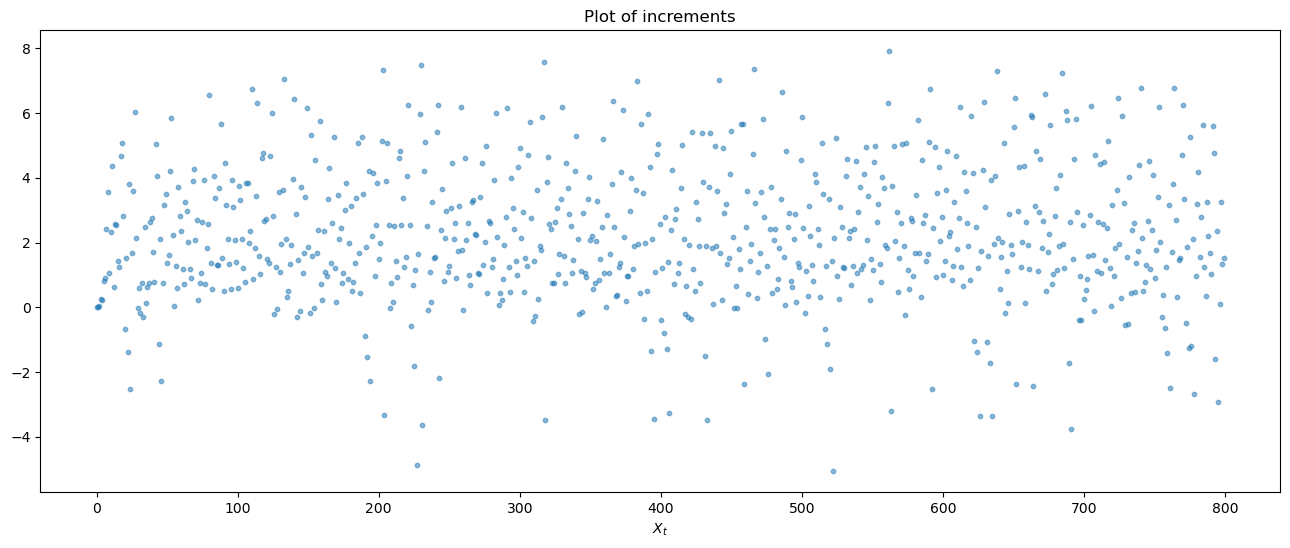

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Read the data, and print the first 5 values
data = pd.read_csv('DataPart5.csv')
print(data.head())
plt.figure(figsize=(16, 6))
plt.scatter(data['x'][ : -1], data['x'][1 : ], label = 'Plot of one-step lag', s = 10, alpha=0.5)
plt.xlabel(rf'$X_{{t-1}}$')
plt.xlabel(rf'$X_{{t}}$')
plt.title(f'Plot of increments')
plt.show()

plt.figure(figsize=(16, 6))
plt.scatter([i for i in range(len(data['x']))], data['x'], label = 'Plot of one-step lag', s = 10, alpha=0.5)
plt.xlabel(rf'$X_{{t-1}}$')
plt.xlabel(rf'$X_{{t}}$')
plt.title(f'Plot of increments')
plt.show()

**Fitting ARMA model and investigation of orders**
- The order of the model will be determined based on an investigation of the autocorrelation function and partial autocorrelation function
- Nonlinearities will be investigated as well

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  800
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1706.171
Date:                Tue, 07 Oct 2025   AIC                           3424.343
Time:                        17:56:27   BIC                           3452.451
Sample:                             0   HQIC                          3435.141
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2351      0.062     36.254      0.000       2.114       2.356
ar.L1          0.2684      0.158      1.701      0.089      -0.041       0.578
ar.L2         -0.0865      0.168     -0.516      0.6

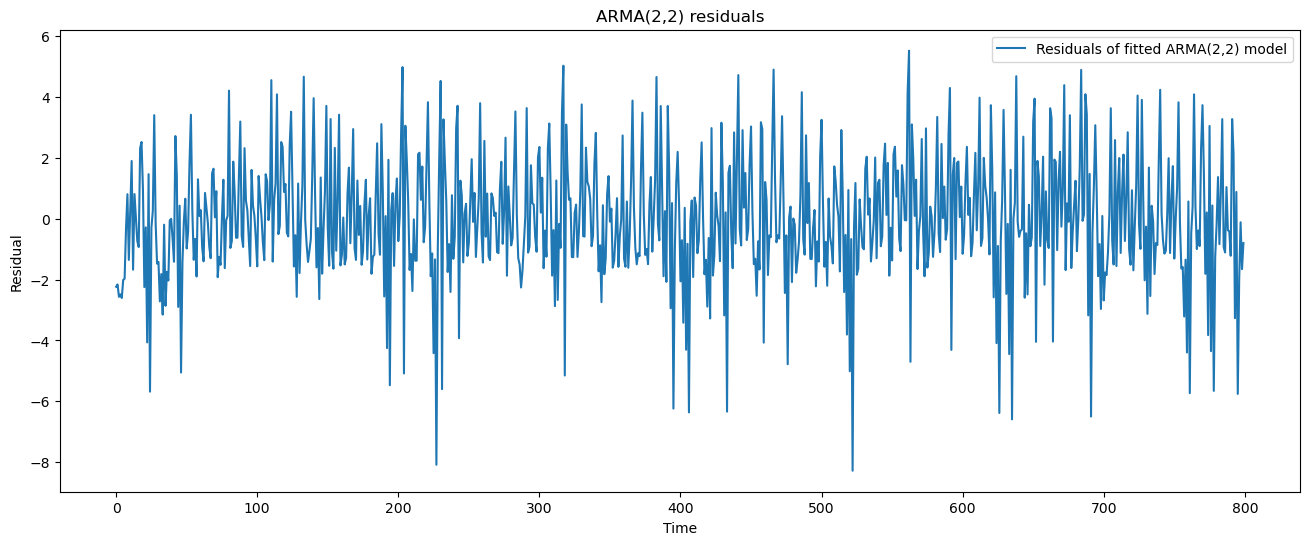

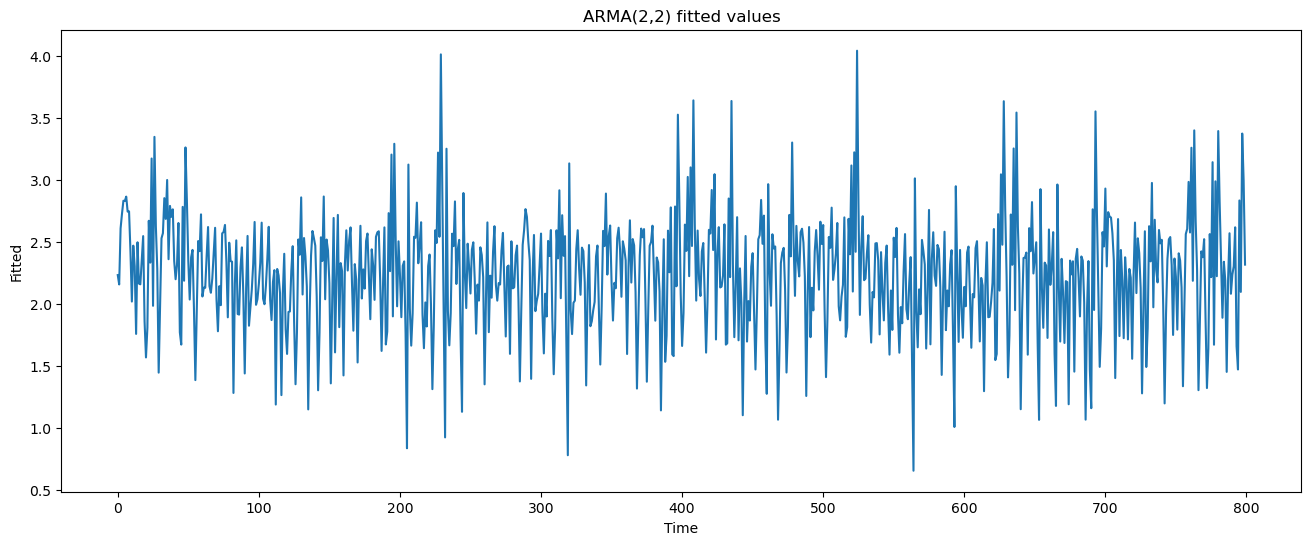

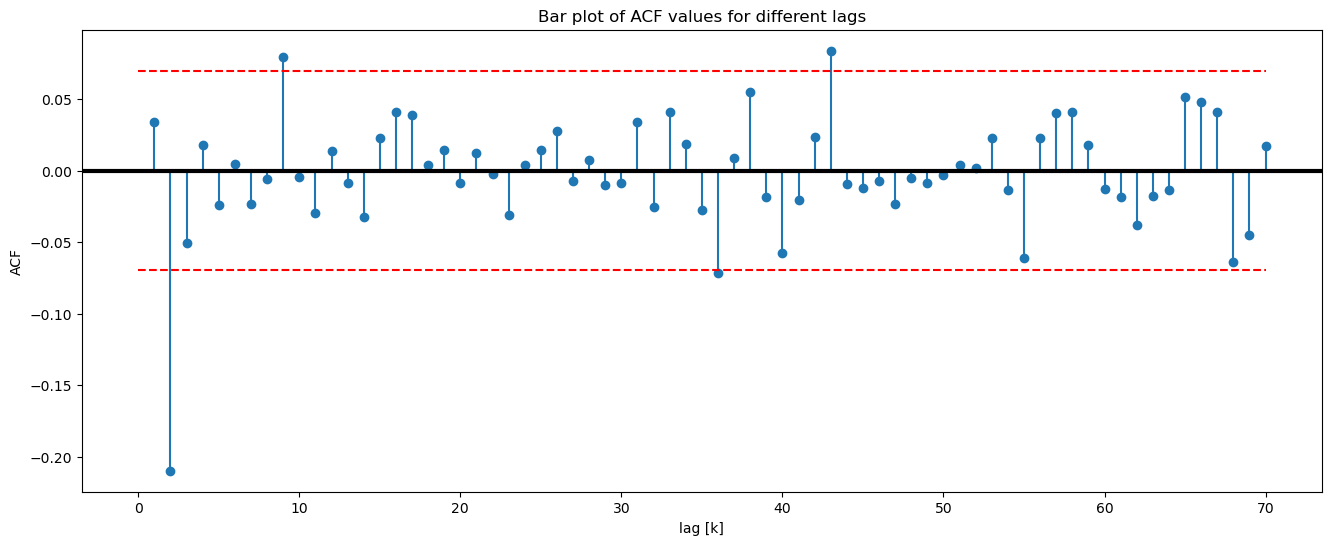

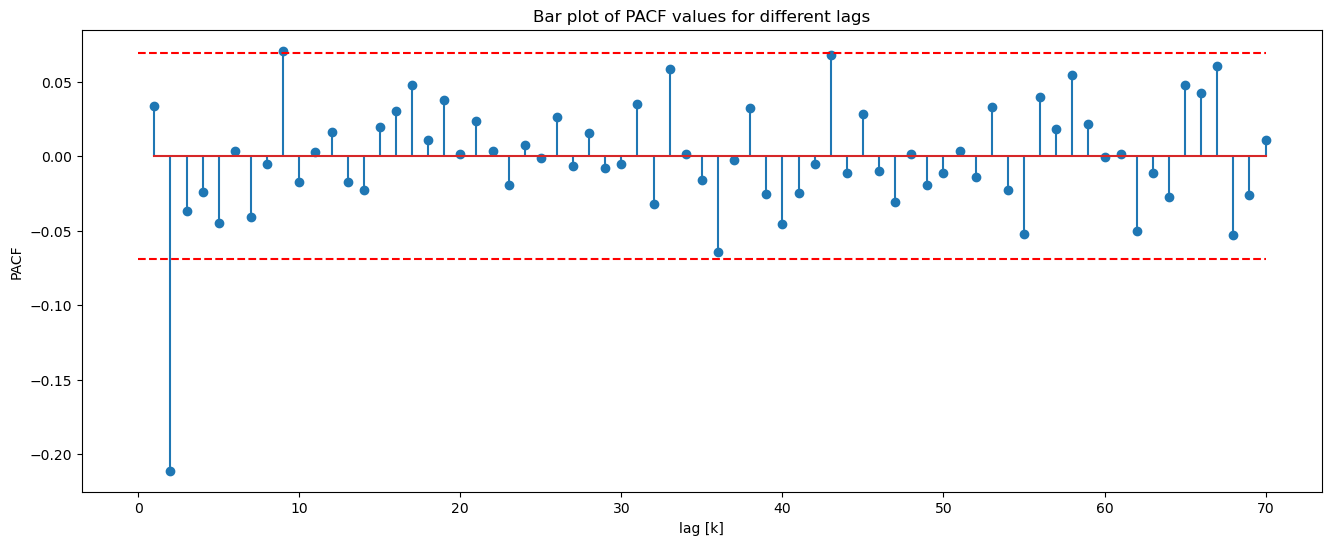

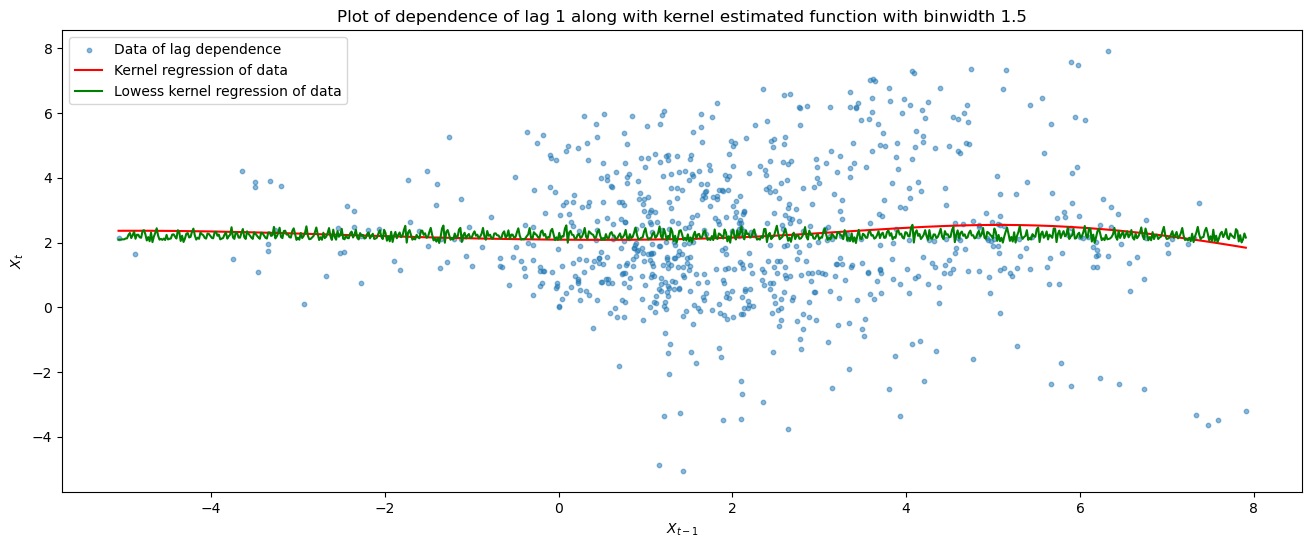

Coefficient of determination for lowess function 0.001323358309428091


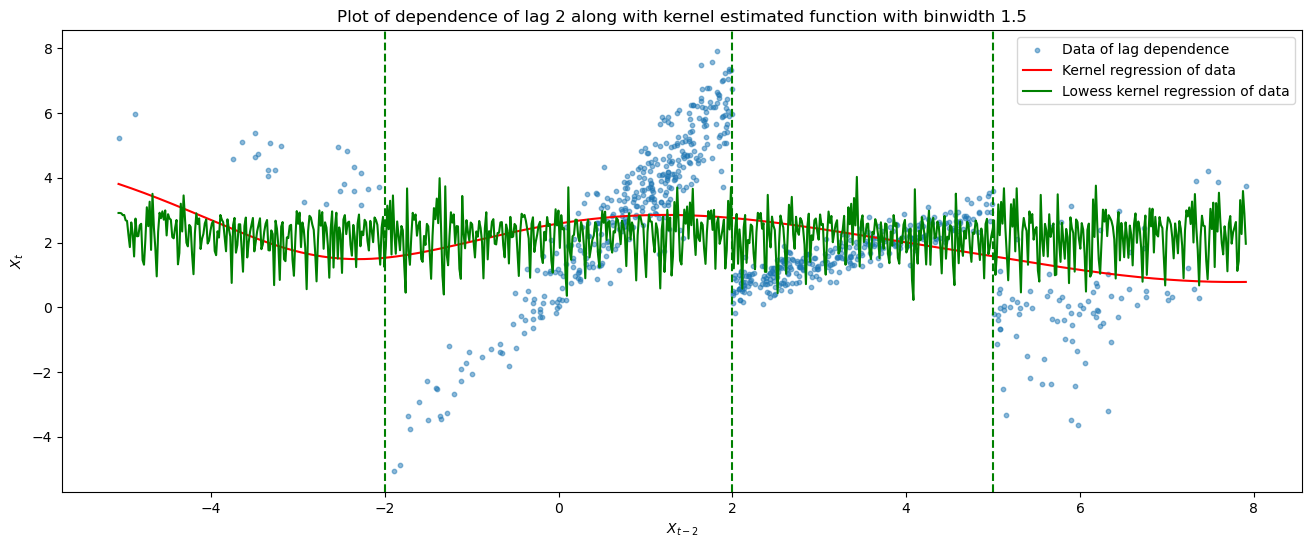

Coefficient of determination for lowess function 0.048488308335370656


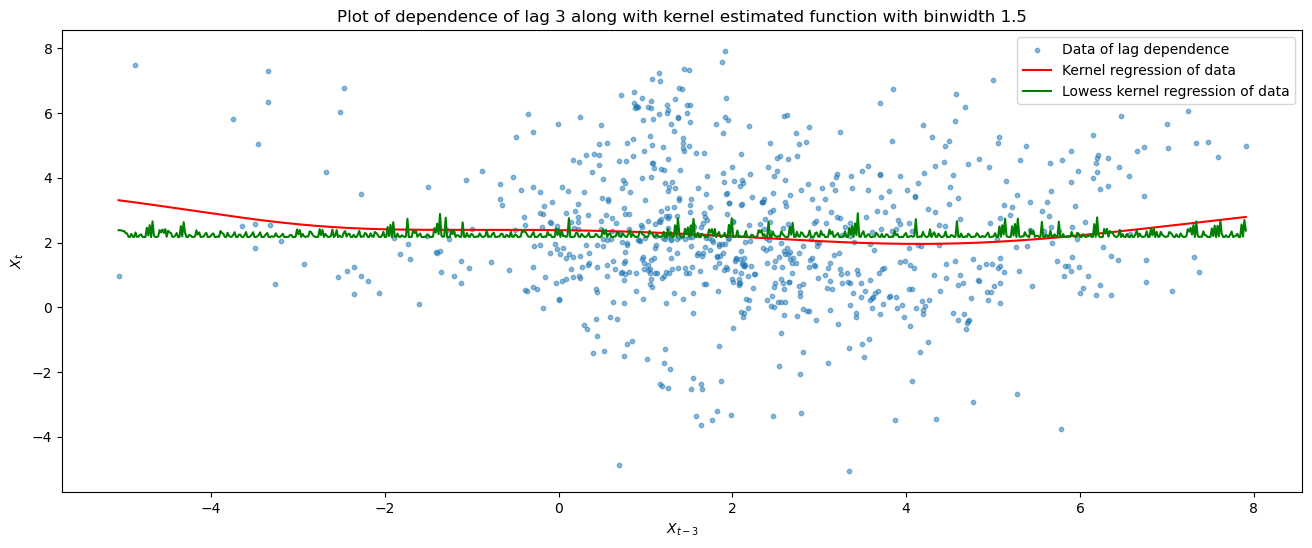

Coefficient of determination for lowess function 0.007570975622524512


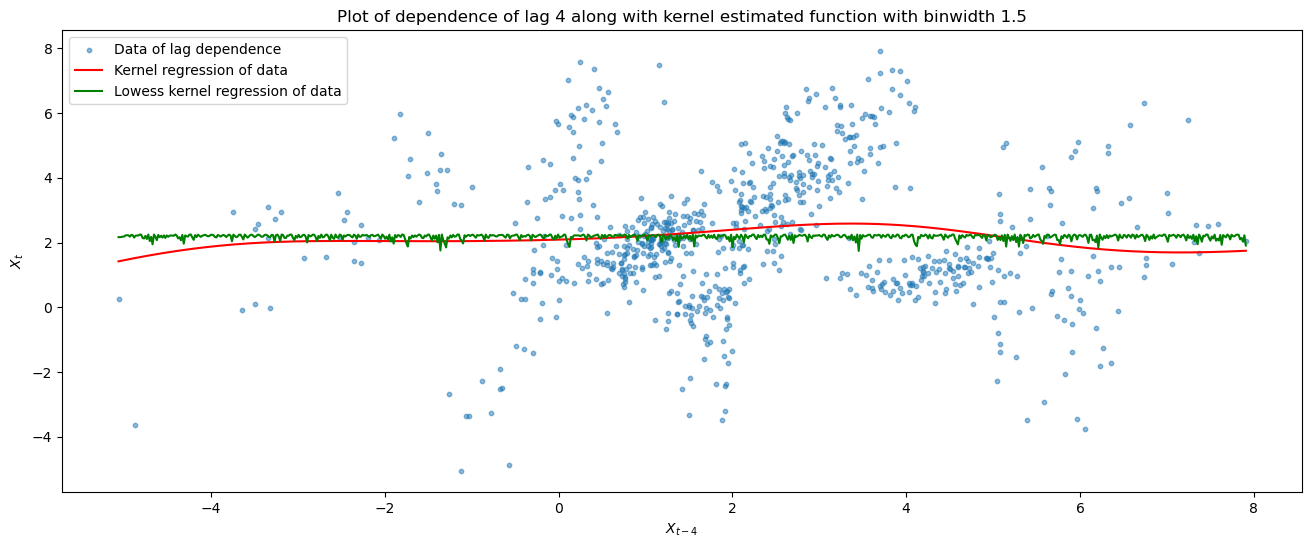

Coefficient of determination for lowess function 0.003052707157119805


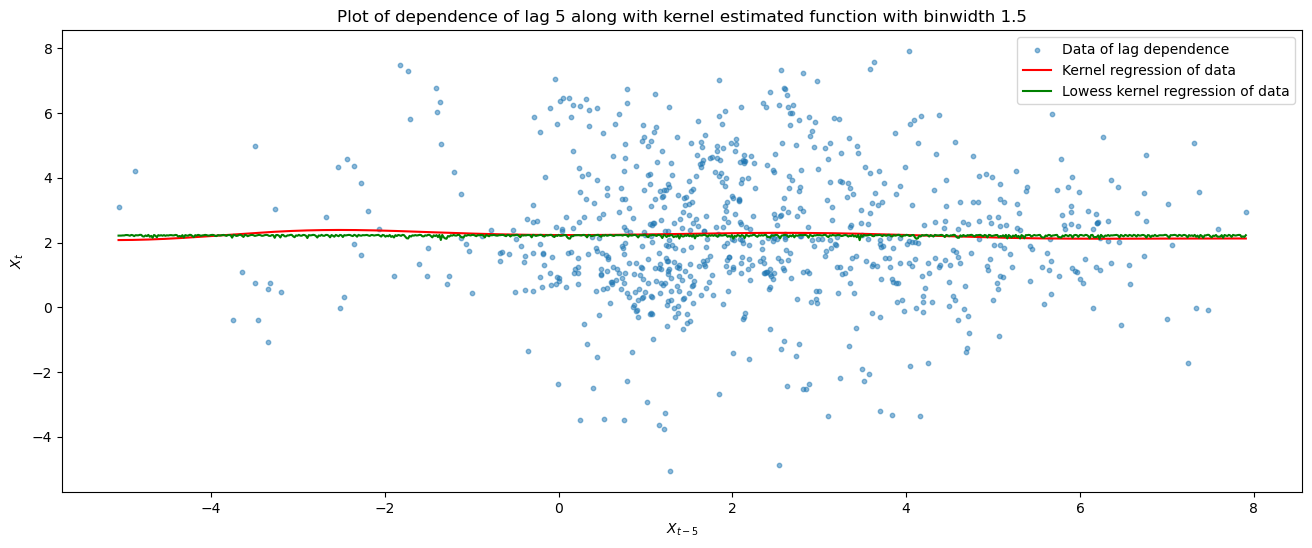

Coefficient of determination for lowess function -0.00018536329053486789


/var/folders/ql/h53w_qjs60509nsf4jbr01c00000gn/T/ipykernel_88073/2391751926.py:134: RuntimeWarning: invalid value encountered in sqrt
  LDF_val = sign(local_polynomial_regression([max(X_t_k)], X_t_k, X_t, h) - local_polynomial_regression([min(X_t_k)], X_t_k, X_t, h)) * np.sqrt(R2_lowess)


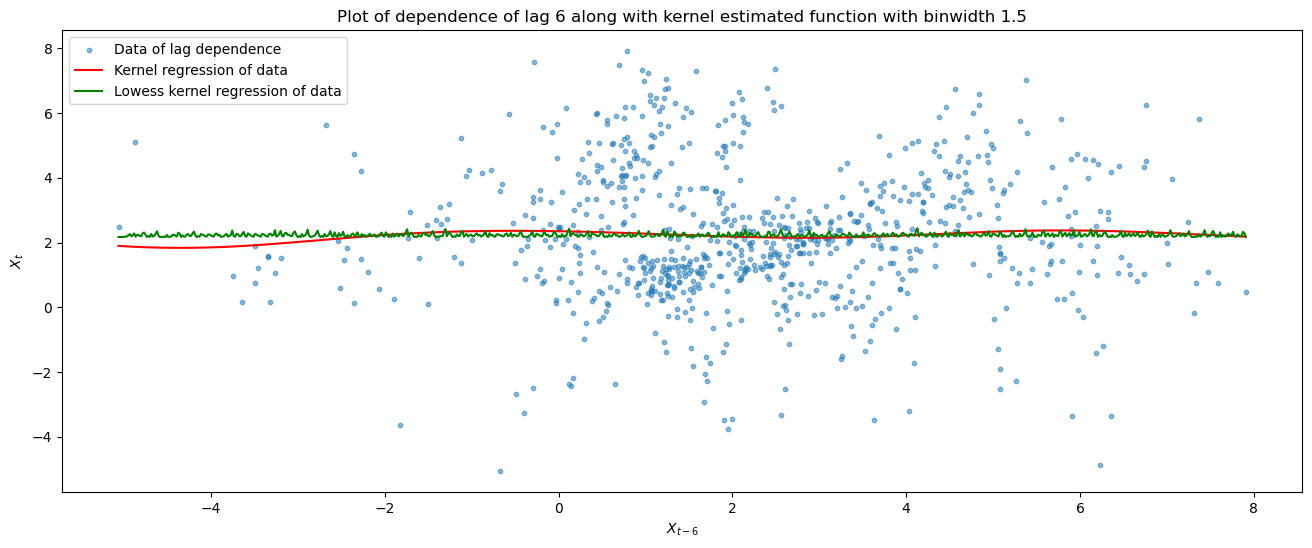

Coefficient of determination for lowess function -0.0014433960366704301


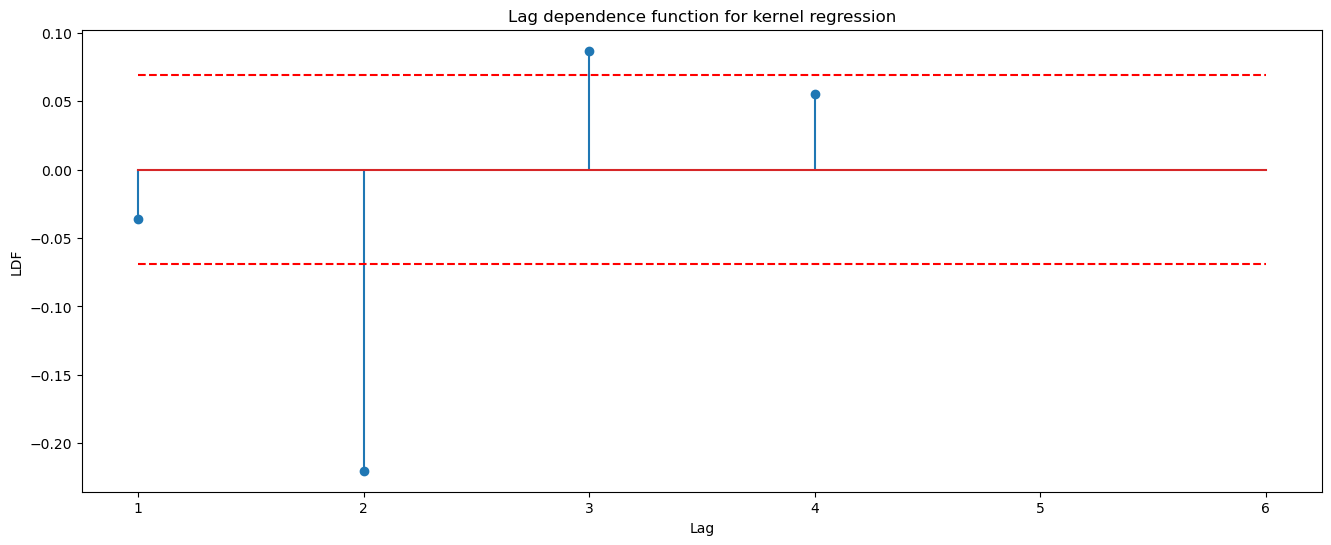

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np


# Try a 0,0 ARMA model

def fit_ARMA(X, p, q, h = 1.2, regression_model = 'linear regression'):
    # Fit the ARMA model without any integrated term
    model = ARIMA(X, order = (p, 0, q))
    result = model.fit()
    print(result.summary())

    plt.figure(figsize=(16, 6))
    plt.plot(result.resid, label = f'Residuals of fitted ARMA({p},{q}) model')
    plt.legend()
    plt.title(f'ARMA({p},{q}) residuals')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(result.fittedvalues)
    plt.title(f'ARMA({p},{q}) fitted values')
    plt.xlabel('Time')
    plt.ylabel('Fitted')
    plt.show()

    # Computing the ACF function
    ACF_values = [1]
    final_lag = 70
    for lag in range(1, final_lag + 1):
        ACF_values.append(ACF(np.array(X), lag))
    
    # Plot ACF 
    plt.figure(figsize=(16, 6))
    plt.stem([lag for lag in range(len(ACF_values))][1 : ], ACF_values[1 : ])
    N = len(X)
    interval_limit = 1.96 / np.sqrt(N)
    plt.hlines([interval_limit, -interval_limit], xmin=0, xmax=len(ACF_values)-1, colors='r', linestyles='dashed')
    plt.title(f'Bar plot of ACF values for different lags')
    plt.xlabel(f'lag [k]')
    plt.ylabel(f'ACF')
    plt.axhline(y=0, color='black', linewidth=3)
    plt.show()

    # Computing PACF 
    pacf_values = pacf(np.array(X), nlags = final_lag)
    plt.figure(figsize=(16, 6))
    plt.stem(range(len(pacf_values))[1 : ], pacf_values[1 : ])
    plt.hlines([interval_limit, -interval_limit], xmin=0, xmax=len(ACF_values)-1, colors='r', linestyles='dashed')
    plt.xlabel('lag [k]')
    plt.ylabel('PACF')
    plt.title("Bar plot of PACF values for different lags")
    plt.show()

    # Strong dependance of lag 2! => we will conclude that it is likely an ARMA(2, 2) model

    # Computing the LDF 
    LDF_values = [1]
    LDF_final_lag = 6
    for lag in range(1, LDF_final_lag + 1):
        LDF_values.append(LDF(np.array(X), lag, h))
    plt.figure(figsize=(16, 6))
    plt.stem(range(len(LDF_values))[1 : ], LDF_values[1 : ])
    N = len(X)
    interval_limit = 1.96 / np.sqrt(N)
    plt.hlines([interval_limit, -interval_limit], xmin=1, xmax=len(LDF_values)-1, colors='r', linestyles='dashed')
    plt.title(f'Lag dependence function for {regression_model}')
    plt.xlabel('Lag')
    plt.ylabel('LDF')
    plt.show()



def kernel(x, kernel_function = 'gaussian'):

    # Define different cases of kernel functions
    if kernel_function == 'gaussian':
        return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    elif kernel_function == 'tricube':
        in_interval = np.abs(x) <= 1
        weights = np.zeros_like(x, dtype=float) # Initialie empty weights
        weights[in_interval] = (1 - np.abs(x[in_interval]) ** 3)**3 # Substitute for valid values
        return weights
    else:
        return 1 / 2 * ((x >= -1) & (x <= 1)).astype(float)
    

def f(X, Y, x, h):

    # Return the kernel regression function
    return sum(kernel((x - X) / h) * Y) / sum(kernel((x - X) / h))

def sign(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0

def LDF(X, k, h):
    X_t, X_t_k = X[k : ], X[ : -k] # Define the current and lagged time series
    X_span = np.linspace(min(X_t_k), max(X_t_k), len(X_t))
    X_t_hat = [] # This will store regressional values

    # Time series estimation as a function of lagged time series
    for x in X_span:
        X_t_hat.append(sum(kernel((x - X_t_k) / h) * X_t) / sum(kernel((x - X_t_k) / h)))
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Plot of dependence of lag {k} along with kernel estimated function with binwidth {h}')
    plt.scatter(X_t_k, X_t, s = 10, alpha = 0.5, label = 'Data of lag dependence')
    plt.plot(X_span, X_t_hat, label = 'Kernel regression of data', color = 'red')
    X_t_hat_lowess = lowess(X_t, X_t_k, frac = 1, return_sorted = False)
    plt.plot(X_span, X_t_hat_lowess, label = 'Lowess kernel regression of data', color = 'green')
    if k == 2:
        regime_split_list = [-2, 2, 5] # Define where the regime is swapped
        for regime_split in regime_split_list:
            plt.axvline(x = regime_split, linestyle = '--', color = 'green')
    plt.legend()
    plt.xlabel(rf'$X_{{t-{k}}}$')
    plt.ylabel(rf'$X_t$')
    plt.show()

    # Trial of function solution
    R2_lowess = 1 - np.sum((X_t - X_t_hat_lowess)**2) / np.sum((X_t - np.mean(X_t) )**2) # Coefficcient of determination for lowess
    print(f'Coefficient of determination for lowess function {R2_lowess}')
    
    # Computing the LDF
    LDF_val = sign(local_polynomial_regression([max(X_t_k)], X_t_k, X_t, h) - local_polynomial_regression([min(X_t_k)], X_t_k, X_t, h)) * np.sqrt(R2_lowess)
    return LDF_val


def local_polynomial_regression(X_span, X, Y, h, degree_of_polynomial = 3):
    X_hat = []
    for x in X_span:
        weights = kernel((x - X) / h)
        X_design = np.vander(X - x, N = degree_of_polynomial + 1, increasing = True) # Create the design matrix
        
        # Weighted least squares
        W = np.diag(weights)
        XT_W = X_design.T @ W
        try:
            theta = np.linalg.solve(XT_W @ X_design, XT_W @ Y) # Least squares inverse for optimization
            X_hat.append(theta[0])
        except np.linalg.LinAlgError: # if an error occurs for the optimization, just a safety function
            X_hat.append(np.nan)
            
    return np.array(X_hat)


def ACF(X, k):
    X_t, X_t_k = X[k : ], X[ : -k]
    return (np.sum((X_t - np.mean(X)) * (X_t_k - np.mean(X))) / (len(X) - k)) / np.var(X) # scalar product to compute the covariance between the two time series


fit_ARMA(data['x'], 2, 2, h = 1.5, regression_model = 'kernel regression')

**Investigation of plots:**
- As can be observed in the second image, it clearly looks like the model have different regimes, dependant on second order lag, a SETAR model with 4 regimes, divided by [-2, 0, 2, 5]. This model of 4 regimes is a SETAR(4, 2, 2) model and will be investigated further and fitted.

- The model should produce white noise when fitted, as we see that four different regimes have different dependancies to the X_t_minus_2

- The LDF function is essentially an indicator function of if we have varying parameters, if the fit is much better using a local function estimation, rather than the generalized linear model (linear in parameters)

- A strong value of it shows that the regression benefits largely of a local polynomial estimation, that cannot be described by linear relationships => non-linearities in the variables

**Fitting a SETAR(4, 2, 2) model to the data**

In [3]:
from statsmodels.tsa.arima.model import ARIMA

def find_SETAR(X, k, thresholds = [], p = 2, q = 2):
    X_t, X_t_k = X[k : ], X[ : -k] # Determine the current and lagged time series
    X_span = np.linspace(min(X_t_k), max(X_t_k), len(X_t))
    X_t_hat = []

    if len(thresholds) > 1:
        indices_in_regime = {} 
        for threshold_idx in range(len(thresholds) + 1):

            # Define the regimes and what data are in which regime
            if threshold_idx == 0:
                regime_indices = np.where(X_t_k <= thresholds[0])[0]
                indices_in_regime[f'regime_{threshold_idx}'] = regime_indices
                regime_indices_next = np.where((X_t_k > thresholds[0]) & (X_t_k <= thresholds[1]))[0]
                indices_in_regime[f'regime_{threshold_idx + 1}'] = regime_indices_next
            elif threshold_idx == len(thresholds):
                regime_indices = np.where(X_t_k > thresholds[-1])[0]
                indices_in_regime[f'regime_{threshold_idx}'] = regime_indices
            else:
                regime_indices = np.where((X_t_k > thresholds[threshold_idx-1]) & (X_t_k <= thresholds[threshold_idx]))[0]
                indices_in_regime[f'regime_{threshold_idx}'] = regime_indices
    
    # For all the data of each regime, fit an ARMA(2, 2) model to the data
    for regime, indices in indices_in_regime.items():
        print(f'Model summary for {regime}')
        model = ARIMA(X[indices], order = (p, 0, q))
        result = model.fit()
        print(result.params)
    
    return indices_in_regime


indices_in_regime = find_SETAR(data['x'], k = 2, thresholds=[-2, 2, 5])

Model summary for regime_0
const    -3.113524
ar.L1     0.167566
ar.L2     0.096125
ma.L1    -0.263275
ma.L2    -0.736354
sigma2    0.404111
dtype: float64
Model summary for regime_1


/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/b

const     0.818699
ar.L1     0.748721
ar.L2     0.021044
ma.L1    -0.876206
ma.L2     0.117532
sigma2    0.677841
dtype: float64
Model summary for regime_2
const     3.252560
ar.L1     0.886857
ar.L2    -0.314973
ma.L1    -1.137880
ma.L2     0.461499
sigma2    0.673498
dtype: float64
Model summary for regime_3


/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471

const     5.964699
ar.L1    -0.085775
ar.L2     0.802745
ma.L1    -0.078181
ma.L2    -0.918501
sigma2    0.440384
dtype: float64
